## MNIST Classification


In [1]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from functools import partial

In [2]:
# transforms.py

from torchvision import transforms

# Train Phase transformations
def mnist_transforms():
  train_transforms = transforms.Compose([
                                        transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                        transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                        ])

  # Test Phase transformations
  test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])
  
  return train_transforms, test_transforms

In [3]:
# dataset.py

from torchvision import datasets

def mnist():
  train_transforms, test_transforms = mnist_transforms()
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  return train, test

In [4]:
# utils.py

import sys
import matplotlib.pyplot as plt

def plot_results(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  for label, losses in train_losses.items():
    axs[0, 0].plot(losses, label = label)
  axs[0, 0].set_title("Training Loss")
  axs[0, 0].legend()

  for label, acc in train_acc.items():
    axs[1, 0].plot(acc, label = label)
  axs[1, 0].set_title("Training Accuracy")
  axs[1, 0].legend()

  for label, losses in test_losses.items():
    axs[0, 1].plot(losses, label = label)
  axs[0, 1].set_title("Test Loss")
  axs[0, 1].legend()

  for label, acc in test_acc.items():
    axs[1, 1].plot(acc, label = label)
  axs[1, 1].set_title("Test Accuracy")
  axs[1, 1].legend()

def printout(msg):
  print(msg)
  sys.stdout.flush()

def show_images_from_loader(data_loader, image_count=60):
  figure = plt.figure()
  for data, target in data_loader:
    for index in range(data.shape[0]):
      plt.subplot(6, 10, index+1)
      plt.axis('off')
      plt.imshow(data[index].numpy().squeeze(), cmap='gray_r')
      if index + 1 == image_count:
        break
    break

# Show misclassified images with respect to a model
def show_misclassified_images_from_model(model, model_path, data_loader, class_labels, image_count):
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  correct = 0
  figure = plt.figure(figsize=(15,15))
  count = 0
  with torch.no_grad():
      for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          for idx in range(len(pred)):
            i_pred, i_act = pred[idx], target[idx]
            if i_pred != i_act:
                annotation = "Actual: %s, Predicted: %s" % (class_labels[i_act], class_labels[i_pred])
                count += 1
                plt.subplot(image_count/5, 5, count)
                plt.axis('off')
                plt.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
                plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=13)
            if count == image_count:
                return

In [5]:
# regularizers.py

def l1_loss(model, loss, lambda_l1):
  l1 = 0
  for p in model.parameters():
    l1 = l1 + p.abs().sum()
  loss = loss + lambda_l1 * l1
  return loss

In [6]:
# train.py

from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, opts, hyper_params):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  train_losses = []
  train_acc = []

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # L1 Regularization
    if ModelOpts.L1 in opts:
      l1_lambda = hyper_params.get("l1_lambda", 0.1)
      loss = l1_loss(model, loss, l1_lambda)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return train_losses, train_acc

In [7]:
# test.py

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_losses = []
    test_acc = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc

In [8]:
# models.py

class ModelOpts:
    L1 = "L1"
    L2 = "L2"
    BN = "BN"
    GBN = "GBN"
    Save = "Save Model"

    def get_name(opts):
      nameParts = []
      for opt in opts:
        if opt == ModelOpts.Save:
          continue
        nameParts.append(opt)
      return "+".join(nameParts)


# Source: https://github.com/apple/ml-cifar-10-faster/blob/master/utils.py#L147
class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

class MNIST_S6(nn.Module):
  
    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1):
      return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            self.bn(out_channels),
            nn.Dropout(0.01))
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))

    def __init__(self, opts=[]):
        super(MNIST_S6, self).__init__()
        if ModelOpts.GBN in opts:
          self.bn = partial(GhostBatchNorm, num_splits=2)
        else:
          self.bn = nn.BatchNorm2d
        self.conv1 = self.conv_block(1, 10, 3)
        self.conv2 = self.conv_block(10, 10, 3, 0)
        self.conv3 = self.conv_block(10, 11, 3)
        self.conv4 = self.conv_block(11, 11, 3, 0)
        self.conv5 = self.conv_block(11, 12, 3)
        self.conv6 = self.conv_block(12, 12, 3, 0)
        self.conv8 = self.out_block(12, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Load Dataset

In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", cuda, "Device", device)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# load dataset
train_data, test_data = mnist()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True Device cuda


### Visualize images, train/test. To verify if transforms are applied appropriately

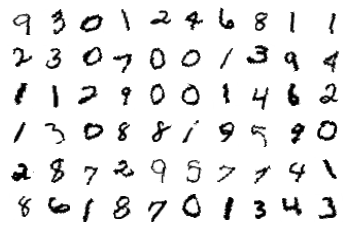

In [10]:
show_images_from_loader(train_loader)

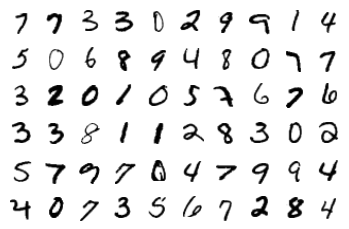

In [11]:
show_images_from_loader(test_loader)

### Verify model & its parameters

In [12]:
model = MNIST_S6().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 11, 13, 13]             990
             ReLU-11           [-1, 11, 13, 13]               0
      BatchNorm2d-12           [-1, 11, 13, 13]              22
          Dropout-13           [-1, 11, 13, 13]               0
           Conv2d-14           [-1, 11,

### Train/Test Model

Executing model with Options ['L1', 'BN']
Epoch: 0


Loss=0.3098923861980438 Batch_id=468 Accuracy=90.30: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s]



Test set: Average loss: 0.0594, Accuracy: 9802/10000 (98.02%)

Epoch: 1


Loss=0.18874341249465942 Batch_id=468 Accuracy=95.61: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s]



Test set: Average loss: 0.0587, Accuracy: 9805/10000 (98.05%)

Epoch: 2


Loss=0.25195157527923584 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:39<00:00, 11.90it/s]



Test set: Average loss: 0.0523, Accuracy: 9843/10000 (98.43%)

Epoch: 3


Loss=0.2090906798839569 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]



Test set: Average loss: 0.0395, Accuracy: 9880/10000 (98.80%)

Epoch: 4


Loss=0.15906235575675964 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s]



Test set: Average loss: 0.0418, Accuracy: 9864/10000 (98.64%)

Epoch: 5


Loss=0.16932609677314758 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]



Test set: Average loss: 0.0361, Accuracy: 9884/10000 (98.84%)

Epoch: 6


Loss=0.14769509434700012 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]



Test set: Average loss: 0.0229, Accuracy: 9917/10000 (99.17%)

Epoch: 7


Loss=0.13157199323177338 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s]



Test set: Average loss: 0.0222, Accuracy: 9936/10000 (99.36%)

Epoch: 8


Loss=0.12562522292137146 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]



Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99.04%)

Epoch: 9


Loss=0.22506588697433472 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]



Test set: Average loss: 0.0282, Accuracy: 9908/10000 (99.08%)

Epoch: 10


Loss=0.17974989116191864 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

Epoch: 11


Loss=0.12302246689796448 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s]



Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

Epoch: 12


Loss=0.09645261615514755 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]



Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

Epoch: 13


Loss=0.21751472353935242 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]



Test set: Average loss: 0.0221, Accuracy: 9922/10000 (99.22%)

Epoch: 14


Loss=0.17827394604682922 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s]



Test set: Average loss: 0.0311, Accuracy: 9901/10000 (99.01%)

Epoch: 15


Loss=0.14352008700370789 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:39<00:00, 11.88it/s]



Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

Epoch: 16


Loss=0.12535081803798676 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:39<00:00, 11.97it/s]



Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

Epoch: 17


Loss=0.21527552604675293 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]



Test set: Average loss: 0.0184, Accuracy: 9946/10000 (99.46%)

Epoch: 18


Loss=0.08317543566226959 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]



Test set: Average loss: 0.0187, Accuracy: 9932/10000 (99.32%)

Epoch: 19


Loss=0.1521538943052292 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]



Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

Epoch: 20


Loss=0.08353513479232788 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:39<00:00, 11.90it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

Epoch: 21


Loss=0.09154956787824631 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]



Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

Epoch: 22


Loss=0.13429519534111023 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

Epoch: 23


Loss=0.12458738684654236 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:39<00:00, 11.77it/s]



Test set: Average loss: 0.0175, Accuracy: 9954/10000 (99.54%)

Epoch: 24


Loss=0.08458277583122253 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s]



Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

Executing model with Options ['L2', 'BN']
Epoch: 0


Loss=0.11624333262443542 Batch_id=468 Accuracy=90.66: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0703, Accuracy: 9787/10000 (97.87%)

Epoch: 1


Loss=0.19649581611156464 Batch_id=468 Accuracy=95.67: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average loss: 0.0696, Accuracy: 9774/10000 (97.74%)

Epoch: 2


Loss=0.10648145526647568 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average loss: 0.0399, Accuracy: 9869/10000 (98.69%)

Epoch: 3


Loss=0.057364821434020996 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]



Test set: Average loss: 0.0432, Accuracy: 9871/10000 (98.71%)

Epoch: 4


Loss=0.16189514100551605 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0315, Accuracy: 9906/10000 (99.06%)

Epoch: 5


Loss=0.12273753434419632 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]



Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.19%)

Epoch: 6


Loss=0.0857517421245575 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

Epoch: 7


Loss=0.04161829873919487 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]



Test set: Average loss: 0.0257, Accuracy: 9911/10000 (99.11%)

Epoch: 8


Loss=0.02279648743569851 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]



Test set: Average loss: 0.0252, Accuracy: 9929/10000 (99.29%)

Epoch: 9


Loss=0.11360203474760056 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

Epoch: 10


Loss=0.03984943777322769 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

Epoch: 11


Loss=0.04790021479129791 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]



Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

Epoch: 12


Loss=0.011568604968488216 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

Epoch: 13


Loss=0.07879409939050674 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

Epoch: 14


Loss=0.12048535794019699 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]



Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

Epoch: 15


Loss=0.06447882205247879 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

Epoch: 16


Loss=0.13617171347141266 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)

Epoch: 17


Loss=0.08255019038915634 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

Epoch: 18


Loss=0.015508917160332203 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]



Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

Epoch: 19


Loss=0.007589319720864296 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]



Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

Epoch: 20


Loss=0.06266085058450699 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

Epoch: 21


Loss=0.12415305525064468 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]



Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

Epoch: 22


Loss=0.0592363066971302 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

Epoch: 23


Loss=0.05433240160346031 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:38<00:00, 12.27it/s]



Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

Epoch: 24


Loss=0.08117466419935226 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

Executing model with Options ['L1', 'L2', 'BN']
Epoch: 0


Loss=0.28527286648750305 Batch_id=468 Accuracy=90.86: 100%|██████████| 469/469 [00:39<00:00, 12.01it/s]



Test set: Average loss: 0.0683, Accuracy: 9774/10000 (97.74%)

Epoch: 1


Loss=0.25959864258766174 Batch_id=468 Accuracy=95.82: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]



Test set: Average loss: 0.0504, Accuracy: 9837/10000 (98.37%)

Epoch: 2


Loss=0.2292197346687317 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]



Test set: Average loss: 0.0477, Accuracy: 9845/10000 (98.45%)

Epoch: 3


Loss=0.22815491259098053 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]



Test set: Average loss: 0.0418, Accuracy: 9854/10000 (98.54%)

Epoch: 4


Loss=0.25243881344795227 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]



Test set: Average loss: 0.0431, Accuracy: 9863/10000 (98.63%)

Epoch: 5


Loss=0.15421953797340393 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:39<00:00, 12.01it/s]



Test set: Average loss: 0.0341, Accuracy: 9889/10000 (98.89%)

Epoch: 6


Loss=0.1088908463716507 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:39<00:00, 11.90it/s]



Test set: Average loss: 0.0331, Accuracy: 9895/10000 (98.95%)

Epoch: 7


Loss=0.20361030101776123 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s]



Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

Epoch: 8


Loss=0.1883375644683838 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

Epoch: 9


Loss=0.14651229977607727 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average loss: 0.0330, Accuracy: 9893/10000 (98.93%)

Epoch: 10


Loss=0.11191385984420776 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

Epoch: 11


Loss=0.10167955607175827 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]



Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

Epoch: 12


Loss=0.17826467752456665 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:38<00:00, 12.07it/s]



Test set: Average loss: 0.0269, Accuracy: 9906/10000 (99.06%)

Epoch: 13


Loss=0.09701506048440933 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]



Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

Epoch: 14


Loss=0.11795587837696075 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:39<00:00, 11.97it/s]



Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

Epoch: 15


Loss=0.10911503434181213 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

Epoch: 16


Loss=0.09174676239490509 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]



Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

Epoch: 17


Loss=0.09432835131883621 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average loss: 0.0224, Accuracy: 9922/10000 (99.22%)

Epoch: 18


Loss=0.21655181050300598 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]



Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

Epoch: 19


Loss=0.15501761436462402 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]



Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

Epoch: 20


Loss=0.0801495611667633 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

Epoch: 21


Loss=0.12967193126678467 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]



Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

Epoch: 22


Loss=0.11045762151479721 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average loss: 0.0178, Accuracy: 9935/10000 (99.35%)

Epoch: 23


Loss=0.15154315531253815 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]



Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

Epoch: 24


Loss=0.15390430390834808 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average loss: 0.0180, Accuracy: 9936/10000 (99.36%)

Executing model with Options ['GBN', 'Save Model']
Epoch: 0


Loss=0.25159525871276855 Batch_id=468 Accuracy=90.26: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0582, Accuracy: 9836/10000 (98.36%)

Epoch: 1


Loss=0.1206500455737114 Batch_id=468 Accuracy=95.70: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]



Test set: Average loss: 0.0490, Accuracy: 9851/10000 (98.51%)

Epoch: 2


Loss=0.20737935602664948 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]



Test set: Average loss: 0.0344, Accuracy: 9889/10000 (98.89%)

Epoch: 3


Loss=0.12726940214633942 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0385, Accuracy: 9884/10000 (98.84%)

Epoch: 4


Loss=0.020131053403019905 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0346, Accuracy: 9889/10000 (98.89%)

Epoch: 5


Loss=0.12427718192338943 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0268, Accuracy: 9914/10000 (99.14%)

Epoch: 6


Loss=0.08552669733762741 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0308, Accuracy: 9917/10000 (99.17%)

Epoch: 7


Loss=0.07284419983625412 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]



Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

Epoch: 8


Loss=0.0930895134806633 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]



Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

Epoch: 9


Loss=0.037471704185009 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]



Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

Epoch: 10


Loss=0.005987111013382673 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

Epoch: 11


Loss=0.14363105595111847 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

Epoch: 12


Loss=0.04397425055503845 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

Epoch: 13


Loss=0.04557782784104347 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]



Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

Epoch: 14


Loss=0.16775555908679962 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

Epoch: 15


Loss=0.04162408411502838 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:39<00:00, 11.97it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

Epoch: 16


Loss=0.03599679097533226 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]



Test set: Average loss: 0.0205, Accuracy: 9944/10000 (99.44%)

Epoch: 17


Loss=0.05735151842236519 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

Epoch: 18


Loss=0.03619822859764099 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

Epoch: 19


Loss=0.026163814589381218 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

Epoch: 20


Loss=0.019648736342787743 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

Epoch: 21


Loss=0.06590922176837921 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

Epoch: 22


Loss=0.1076921820640564 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

Epoch: 23


Loss=0.05624958872795105 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:38<00:00, 12.27it/s]



Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

Epoch: 24


Loss=0.09242886304855347 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

Executing model with Options ['L1', 'L2', 'GBN']
Epoch: 0


Loss=0.2600533664226532 Batch_id=468 Accuracy=90.53: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]



Test set: Average loss: 0.0583, Accuracy: 9801/10000 (98.01%)

Epoch: 1


Loss=0.24096128344535828 Batch_id=468 Accuracy=95.62: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]



Test set: Average loss: 0.0615, Accuracy: 9792/10000 (97.92%)

Epoch: 2


Loss=0.12415960431098938 Batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]



Test set: Average loss: 0.0510, Accuracy: 9822/10000 (98.22%)

Epoch: 3


Loss=0.21161124110221863 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]



Test set: Average loss: 0.0608, Accuracy: 9800/10000 (98.00%)

Epoch: 4


Loss=0.23071607947349548 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]



Test set: Average loss: 0.0362, Accuracy: 9883/10000 (98.83%)

Epoch: 5


Loss=0.16848349571228027 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]



Test set: Average loss: 0.0276, Accuracy: 9905/10000 (99.05%)

Epoch: 6


Loss=0.28142568469047546 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0248, Accuracy: 9916/10000 (99.16%)

Epoch: 7


Loss=0.26896071434020996 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s]



Test set: Average loss: 0.0285, Accuracy: 9898/10000 (98.98%)

Epoch: 8


Loss=0.2678109407424927 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:39<00:00, 11.88it/s]



Test set: Average loss: 0.0402, Accuracy: 9869/10000 (98.69%)

Epoch: 9


Loss=0.10108073800802231 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]



Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

Epoch: 10


Loss=0.11585772037506104 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

Epoch: 11


Loss=0.1248907744884491 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]



Test set: Average loss: 0.0250, Accuracy: 9905/10000 (99.05%)

Epoch: 12


Loss=0.11479935050010681 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:39<00:00, 11.80it/s]



Test set: Average loss: 0.0250, Accuracy: 9911/10000 (99.11%)

Epoch: 13


Loss=0.12893660366535187 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:39<00:00, 11.88it/s]



Test set: Average loss: 0.0210, Accuracy: 9928/10000 (99.28%)

Epoch: 14


Loss=0.13142499327659607 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:39<00:00, 11.74it/s]



Test set: Average loss: 0.0255, Accuracy: 9910/10000 (99.10%)

Epoch: 15


Loss=0.12474176287651062 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:39<00:00, 11.90it/s]



Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

Epoch: 16


Loss=0.10563196986913681 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s]



Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

Epoch: 17


Loss=0.10110874474048615 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]



Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

Epoch: 18


Loss=0.13487035036087036 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:39<00:00, 11.87it/s]



Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

Epoch: 19


Loss=0.08329185098409653 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]



Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

Epoch: 20


Loss=0.20462465286254883 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]



Test set: Average loss: 0.0168, Accuracy: 9938/10000 (99.38%)

Epoch: 21


Loss=0.11087185144424438 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s]



Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

Epoch: 22


Loss=0.09018447995185852 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s]



Test set: Average loss: 0.0184, Accuracy: 9934/10000 (99.34%)

Epoch: 23


Loss=0.2001625895500183 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s]



Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

Epoch: 24


Loss=0.07187611609697342 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s]



Test set: Average loss: 0.0177, Accuracy: 9937/10000 (99.37%)



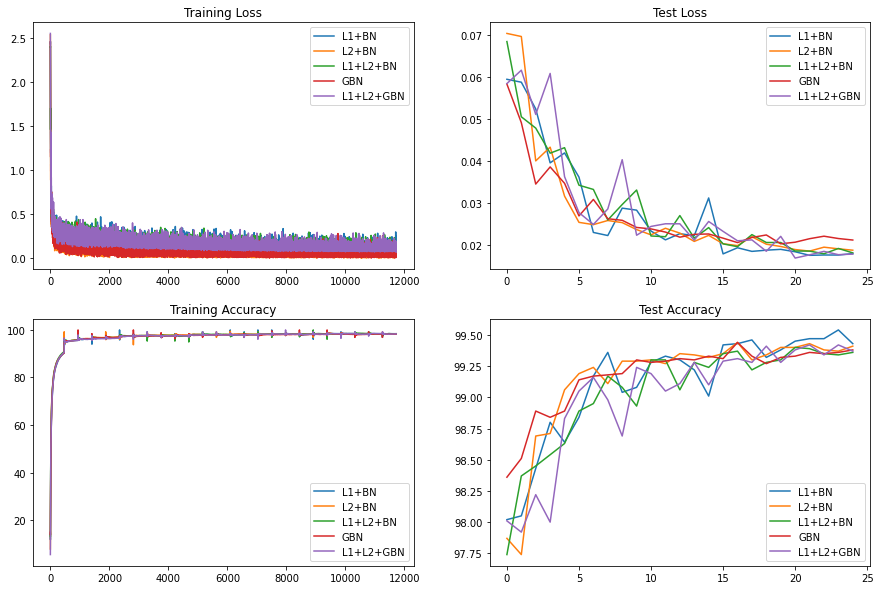

In [13]:
model_options = [
                [ModelOpts.L1, ModelOpts.BN],
                [ModelOpts.L2, ModelOpts.BN],
                [ModelOpts.L1, ModelOpts.L2, ModelOpts.BN],
                [ModelOpts.GBN, ModelOpts.Save],
                [ModelOpts.L1, ModelOpts.L2, ModelOpts.GBN],
              ]

hyper_params = {"l1_lambda": 0.0001}
EPOCHS = 25

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()
for opts in model_options:
  model_name = ModelOpts.get_name(opts)

  train_losses[model_name] = []
  train_acc[model_name] = []
  test_losses[model_name] = []
  test_acc[model_name] = []

  title = f"Executing model with Options {opts}"
  printout(title)
  printout("="*len(title))

  model = MNIST_S6(opts).to(device)
  if ModelOpts.L2 in opts:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  #SstepLR to fine tune learning rate to converge faster
  scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  for epoch in range(EPOCHS):
      printout(f"Epoch: {epoch}")
      tr_loss, tr_acc = train(model, device, train_loader, optimizer, epoch, opts, hyper_params)
      train_losses[model_name].extend(tr_loss)
      train_acc[model_name].extend(tr_acc)
      scheduler.step()
      te_loss, te_acc = test(model, device, test_loader)
      test_losses[model_name].extend(te_loss)
      test_acc[model_name].extend(te_acc)

  if ModelOpts.Save in opts:
    torch.save(model.state_dict(), f"./{model_name}.pth")

plot_results(train_losses, train_acc, test_losses, test_acc)

### Show 25 mis-classified images for Model with GBN

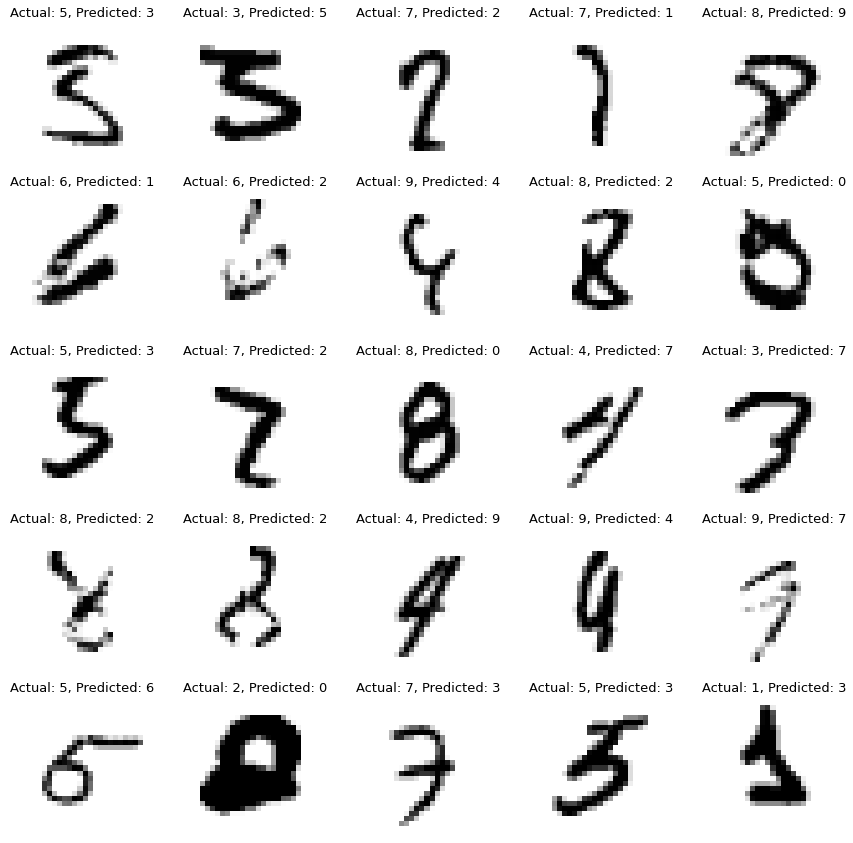

In [14]:
model = MNIST_S6(opts=[ModelOpts.GBN])
model_path = f"{ModelOpts.GBN}.pth"
class_labels = range(10)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)
show_misclassified_images_from_model(model, model_path, test_loader, class_labels, image_count=25)